In [2]:
from graph_tool.all import *
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import torch
import pickle
from multiprocessing import Process, Value, Array
from pyvis.network import Network
import graph_tool as gt
import numpy as np


In [3]:
K = 100

In [4]:

# adjs = np.fromfile('output.bin', dtype=np.uint32).reshape(-1, K)
# adj_dic = {}
# g = gt.Graph()
# for i, adj in zip(range(adjs.shape[0]), adjs):
#     for x in adj:
#         g.add_edge(i, x)
# g

In [5]:
# with open('output_graph.pkl', 'wb') as f:
#     pickle.dump(g, f)
#     f.close()


In [6]:
# Open the file in binary read mode
with open('output_graph.pkl', 'rb') as f:
    
    # Load the object from the file
    g = pickle.load(f)
    
    # Close the file
    f.close()


In [7]:
g

<Graph object, directed, with 1000000 vertices and 100000000 edges, at 0x7ffb637705e0>

In [8]:
vid = np.arange(0, g.num_vertices()).tolist()
all_ind = g.get_in_degrees(vid)
ind_df = pd.DataFrame(all_ind)
ind_df

,0
0,104
1,64
2,73
3,55
4,22
...,...
999995,30
999996,128
999997,43
999998,110


In [9]:
ind_df.describe()

,0
count,1000000.000000
mean,100.000000
std,171.873161
min,0.000000
25%,29.000000
50%,57.000000
75%,109.000000
max,10658.000000


In [10]:
f_gt = open('../evaluation-code/contest-data-release-gt-1m.ibin', 'rb')
f_gt.seek(4)
gt_ids = np.empty((1000000, K), dtype=np.uint32)
for i in range(1000000):
    cur_id = np.fromfile(f_gt, dtype=np.uint32, count=1)[0]
    gt_ids[cur_id] = np.fromfile(f_gt, dtype=np.uint32, count=K)


In [11]:
gt_ids.shape

(1000000, 100)

In [12]:
f_res = open('output.bin', 'rb')
graph_res = np.fromfile(f_res, dtype=np.uint32).reshape(-1, K)
f_res.close()

for i in range(graph_res.shape[0]):
    unique_vals = np.unique(graph_res[i])
    if len(unique_vals) == graph_res.shape[1]:
        pass
        # print("All elements in graph_res[{}] are unique".format(i))
    else:
        print("There are duplicate elements in graph_res[{}]: {}".format(i, unique_vals))


In [13]:
graph_res

array([[513548, 964580, 510954, ..., 450783, 703797, 368286],
       [182423, 555328, 481001, ..., 244628,  46471, 552387],
       [654596, 319311, 115908, ...,  84966, 702534, 416532],
       ...,
       [259154, 542208, 864029, ..., 366741, 878759, 802517],
       [616694, 916714, 838316, ..., 771087, 233660, 186672],
       [ 65364, 769904, 391230, ..., 528604, 294449, 582554]],
      dtype=uint32)

In [14]:
graph_res[1], gt_ids[1]

(array([182423, 555328, 481001, 870285, 105516, 379912, 767419, 234646,
         14593, 611263, 823224, 800336, 375059, 116483, 176962, 287145,
        879562,  30211, 691407, 662105, 236970, 797638, 478318,  57877,
        949568, 929959, 765426, 403352, 293805, 155457, 558088, 252996,
        501898, 297621, 262514, 111451, 782534, 791048, 648460, 819288,
        900516, 728079, 240993, 527817, 983340, 926564, 413899, 951558,
        485810, 789265, 215059, 227659, 524707, 449789, 879774, 945364,
        314083, 445653, 387173, 913225, 860499, 499465, 481872, 116577,
         56237, 836803, 662816, 757656, 319471, 891329, 900657, 769486,
        187863, 491194, 257503, 190437, 909537, 774366, 830083, 597076,
        839464, 495226, 292169, 977571, 578385, 421420, 132079, 728161,
        759135, 532606, 480445, 873091, 747105, 665991, 554666, 870334,
        324055, 244628,  46471, 552387], dtype=uint32),
 array([182423, 555328, 481001, 870285, 105516, 379912, 767419, 234646,
        

In [15]:
a = np.isin(gt_ids[1], graph_res[1])
a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [16]:
import multiprocessing as mp

def process_chunk(start_idx, end_idx):
    chunk_hit_mx = np.zeros((end_idx-start_idx, K), dtype=np.uint32)
    for i in range(start_idx, end_idx):
        mask = np.isin(gt_ids[i], graph_res[i])
        hit_indices = np.where(mask)[0]
        gt_indices = np.where(mask == True)[0]
        chunk_hit_mx[i-start_idx, gt_indices] = 1
    return chunk_hit_mx

# number of worker processes
num_procs = mp.cpu_count()

# chunk size
chunk_size = 10**4

# create pool of worker processes
pool = mp.Pool(processes=num_procs)

# submit jobs to pool
results = []
for i in range(0, 10**6, chunk_size):
    results.append(pool.apply_async(process_chunk, args=(i, min(i+chunk_size, 10**6))))

# collect results and combine into final hit_mx array
hit_mx = np.concatenate([r.get() for r in results], axis=0)

# close pool
pool.close()
pool.join()


In [17]:
hit_df = pd.DataFrame(hit_mx)
hit_df['recall'] = hit_df.sum(axis=1) / K

In [18]:
recall_ind_df = pd.DataFrame({'recall': hit_df['recall'], 'indegree': all_ind})
recall_ind_df

,recall,indegree
0,1.00,104
1,0.95,64
2,1.00,73
3,1.00,55
4,0.97,22
...,...,...
999995,1.00,30
999996,1.00,128
999997,0.95,43
999998,1.00,110


<Axes: xlabel='indegree', ylabel='recall'>

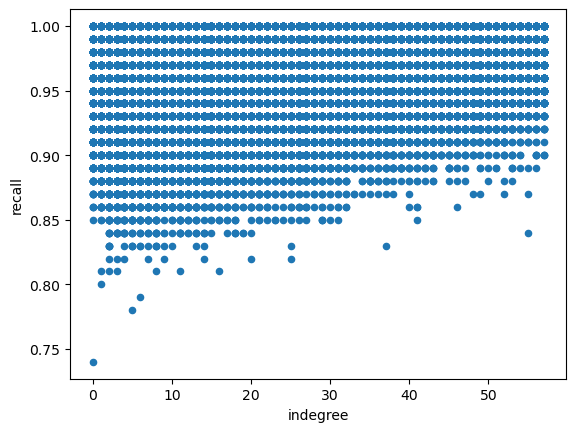

In [32]:
sorted_df = recall_ind_df.sort_values(by='indegree').iloc[:-500000:,]
sorted_df.plot(x='indegree', y='recall', kind='scatter')

In [31]:
sorted_df.describe(percentiles=np.arange(0, 1, 0.1))

,recall,indegree
count,950000.000000,950000.000000
mean,0.987038,72.313253
std,0.019695,61.876262
min,0.740000,0.000000
0%,0.740000,0.000000
10%,0.960000,14.000000
20%,0.980000,23.000000
30%,0.990000,32.000000
40%,0.990000,42.000000
50%,1.000000,54.000000


In [1]:
recall_ind_df.polt()

NameError: name 'recall_ind_df' is not defined

In [34]:
hit_loc_mean_df = pd.DataFrame(hit_df.describe().loc['mean'])

In [35]:
# pd.set_option('display.max_rows', None)
hit_loc_mean_df['id'] = hit_loc_mean_df.index.tolist()
hit_loc_mean_df

ValueError: Length of values (1000000) does not match length of index (100)

In [17]:
# Function to find reverse k-nearest neighbors
def reverse_knn(adj_list, k):
    # Initialize empty dictionary to store rKNN counts
    rknn_counts = {}
    # Iterate over every vertex in the graph
    for i, vertex in enumerate(adj_list):
        # Initialize count of rKNNs to 0
        count_rknn = 0
        # Iterate over every other vertex in the graph
        for j, other_vertex in enumerate(adj_list):
            # Skip the current vertex
            if i == j:
                continue
            # If the current vertex is one of the K nearest neighbors of the other vertex,
            # increment the rKNN count of the current vertex
            if i in other_vertex[:k]:
                count_rknn += 1
        # Store the rKNN count of the current vertex in the dictionary
        rknn_counts[i] = count_rknn
    # Return the dictionary of rKNN counts
    return rknn_counts


In [18]:
import numpy as np
import multiprocessing as mp

# Function to find reverse k-nearest neighbors for a chunk of vertices
def reverse_knn_chunk(adj_list, start, end, k):
    # Initialize empty dictionary to store rKNN counts for this chunk
    rknn_counts = {}
    # Iterate over every vertex in the chunk
    for i in range(start, end):
        # Get the current vertex
        vertex = adj_list[i]
        # Initialize count of rKNNs to 0
        count_rknn = 0
        # Iterate over every other vertex in the graph
        for j, other_vertex in enumerate(adj_list):
            # Skip the current vertex
            if i == j:
                continue
            # If the current vertex is one of the K nearest neighbors of the other vertex,
            # increment the rKNN count of the current vertex
            if i in other_vertex[:k]:
                count_rknn += 1
        # Store the rKNN count of the current vertex in the dictionary
        rknn_counts[i] = count_rknn
    # Return the dictionary of rKNN counts for this chunk
    return rknn_counts

# Function to parallelize finding reverse k-nearest neighbors
def parallel_reverse_knn(adj_list, k, num_processes=4):
    # Divide the adjacency list into equal chunks based on the number of processes
    chunk_size = len(adj_list) // num_processes
    chunks = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes)]
    chunks[-1] = (chunks[-1][0], len(adj_list))
    # Create a process pool with the specified number of processes
    pool = mp.Pool(processes=num_processes)
    # Process each chunk in parallel using the process pool
    results = [pool.apply_async(reverse_knn_chunk, args=(adj_list, start, end, k)) for start, end in chunks]
    # Merge the results from all the chunks into a single dictionary of rKNN counts
    rknn_counts = {}
    for result in results:
        rknn_counts.update(result.get())
    # Close the process pool and return the final dictionary of rKNN counts
    pool.close()
    return rknn_counts


In [19]:
# hub_score = parallel_reverse_knn(graph_res, K, 80)
# hub_score

In [20]:
hub_score = reverse_knn(graph_res, K)
hub_score

KeyboardInterrupt: 